Reference: https://pennylane.ai/qml/demos/tutorial_barren_plateaus

고전 최적화에서는 saddle point가 빠른 최적화를 막는 방해 요소임. 이같은 문제는 VQE에서도 등장함. 그리고 random으로 선택된 회로는 best option to start가 아님  

여기서는 barren plateaus에 빠지는 것을 보일 예정

## Exploring the barren plateau problem with PennyLane

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [6]:
np.random.seed(42)

n_q = 4
dev = qml.device("default.qubit", wires=n_q)
gate_set = [qml.RX, qml.RY, qml.RZ]

def rand_circuit(params, random_gate_sequence=None, n_q=None):
    """A random variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        n_q (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    for i in range(n_q):
        qml.RY(np.pi / 4, wires=i)

    for i in range(n_q):
        random_gate_sequence[i](params[i], wires=i)

    for i in range(n_q - 1):
        qml.CZ(wires=[i, i + 1])

    H = np.zeros((2 ** n_q, 2 ** n_q))
    H[0, 0] = 1
    wirelist = [i for i in range(n_q)] 
    return qml.expval(qml.Hermitian(H, wirelist)) 
    # qml.Hermitian은 임의의 행렬을 관측자로 사용할 때 사용 
    # wirelist는 관측할 큐비ㅡㅌ의 리스트, 

이제 기울기와 variance를 계산할건데, 맨 마지막 파라미터의 변화를 저장해서 관찰하자

In [7]:
grad_vals = []
num_samples = 200

for i in range(num_samples):
    gate_sequence = {i: np.random.choice(gate_set) for i in range(n_q)}
    qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
    grad = qml.grad(qcircuit, argnum=0) 
    # argnum = 0의미는 qcircuit의 첫번째 인자를 변수로 보고 그에 대한 미분값을 구하겠다는 의미. 만약 여러개면 [0,1] 이런식으로
    params = np.random.uniform(0, 2 * np.pi, size=n_q)
    gradient = grad(params, random_gate_sequence=gate_sequence, n_q=n_q)
    grad_vals.append(gradient[-1])

print("Variance of the gradients for {} random circuits: {}".format(
    num_samples, np.var(grad_vals)
    )
)
print("Mean of the gradients for {} random circuits: {}".format(
    num_samples, np.mean(grad_vals)
    )
)

Variance of the gradients for 200 random circuits: 0.0060200187991571
Mean of the gradients for 200 random circuits: -0.0008770836210344132


### Evaluate the gradient for more qubits

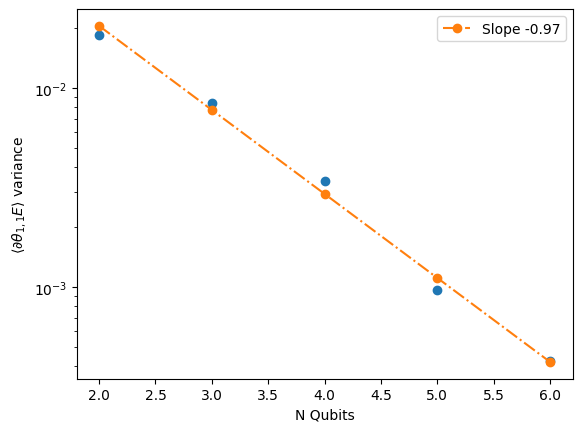

In [ ]:
qubits = [2, 3, 4, 5, 6]
variances = []


for n_q in qubits:
    grad_vals = []
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=n_q)
        qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)

        gate_set = [qml.RX, qml.RY, qml.RZ]
        random_gate_sequence = {i: np.random.choice(gate_set) for i in range(n_q)}

        params = np.random.uniform(0, np.pi, size=n_q)
        gradient = grad(
            params, random_gate_sequence=random_gate_sequence, n_q=n_q
        )
        grad_vals.append(gradient[-1])
    variances.append(np.var(grad_vals))

variances = np.array(variances)
qubits = np.array(qubits)


# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances), 1) # p는 1차 다항식(직선)의 계수를 담고 있는 배열. 
# np.polyfit(x,y,1): x,y의 관계를 가장 잘 설명하는 y=ax+b의 a와 b를 반환 p[0] = a, p[1] = b
# np.plotfit(x, y, 2): ax^2 + bx + c의 a,b,c를 반환

# Plot the straight line fit to the semilog
# semilogy: y축에만 로그 스케일을 적용하여 그래프 표현 
# -> y가 로그를 했는데 선형적이다? == y가 지수적이다
plt.semilogy(qubits, variances, "o") 
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend()
plt.show()